Load the LLM, in this case we are using gpt2

In [1]:
#!pip install transformers

In [2]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=True, local_files_only = True)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            return_dict_in_generate=True,
                                            pad_token_id=tokenizer.eos_token_id).to(device)

In [3]:
tokens_the = tokenizer.tokenize('The')
token_ids = tokenizer.convert_tokens_to_ids(tokens_the)
token_ids = torch.tensor([token_ids])
with torch.no_grad():
    output = model(token_ids)
    logits = output.logits[:, -1, :]
    next_probs = torch.softmax(logits, dim=-1)


In [4]:
np.argmax(next_probs[0])

NameError: name 'np' is not defined

In [ ]:
import numpy as np
def top_k_indices(distribution, k):
    # Use numpy.argsort to get indices of sorted elements
    sorted_indices = np.argsort(-1*distribution)

    # Get the top k indices (last k elements in the sorted array)
    top_k = sorted_indices[:k]

    return top_k

In [ ]:
top_k_indices(next_probs[0],2)

In [ ]:
next_probs[0][366]

In [ ]:
tokenizer.decode(366)

In [ ]:
#!pip install --upgrade pillow

In [5]:
import sys
sys.path.append("../")

In [6]:
#!pip install ssl

In [7]:
from case_studies.gpt2.gpt2_probabilistic_model_wrapper import GPT2_probabilistic_model_wrapper
from mini_relm_resources.automata_examples.the_tokenization_wfa import alphabet

wrapper = GPT2_probabilistic_model_wrapper(50, alphabet, device, model, tokenizer)
#from utilities.mock_probabilistic_model import MockProbabilisticModel
#from pythautomata.base_types.symbol import SymbolStr
#terminal_symbol = SymbolStr(tokenizer.eos_token)
#wrapper = MockProbabilisticModel(alphabet, terminal_symbol)

In [8]:
from mini_relm_resources.automata_examples.the_tokenization_wfa import get_the_tokenization_wfa
guiding_wfa = get_the_tokenization_wfa(wrapper.terminal_symbol)

In [9]:
from utilities.guiding_wfa_sequence_generator import GuidingWDFASequenceGenerator
guiding_generator = GuidingWDFASequenceGenerator(guiding_wfa, None)

In [10]:
guiding_generator.generate_words(10)

[ϵ,
 T,he,gorilla,
 The,house,
 ϵ,
 The,house,
 The,gorilla,
 ϵ,
 The,
 Th,
 Th,e,gorilla]

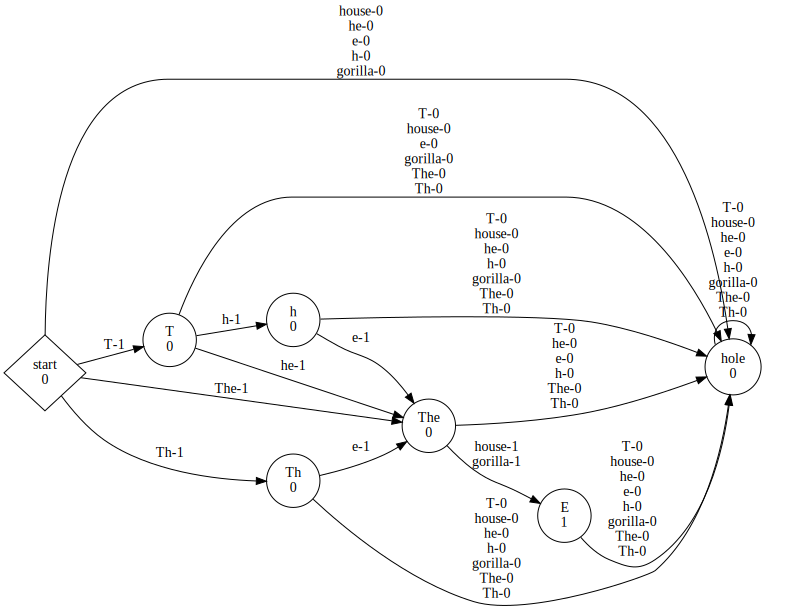

In [11]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(guiding_wfa)

display(graph)

In [12]:
from utilities.syncronic_model_guided_language_model import SyncronicModelGuidedLanguageModel
property_model = guiding_wfa
syncrhronic_model = SyncronicModelGuidedLanguageModel(wrapper, property_model, model_name="GUIDED_GPT2", max_seq_length=10,normalize_outputs=True)

In [13]:
from pymodelextractor.teachers.pac_probabilistic_teacher import PACProbabilisticTeacher
from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
from pythautomata.utilities.probability_partitioner import TopKProbabilityPartitioner, QuantizationProbabilityPartitioner, RankingPartitioner
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.uniform_word_sequence_generator import UniformWordSequenceGenerator
partitioner = QuantizationProbabilityPartitioner(100000)
comparator = WFAPartitionComparator(partitioner)
epsilon = 0.1
delta = epsilon
sequence_generator = guiding_generator
max_states = 30
max_query_length = 100


In [14]:
teacher  = PACProbabilisticTeacher(syncrhronic_model, epsilon = epsilon, delta = delta, max_seq_length = None, comparator = comparator, sequence_generator=guiding_generator, compute_epsilon_star=False)
learner = BoundedPDFAQuantizationNAryTreeLearner(partitioner, max_states, max_query_length, None, generate_partial_hipothesis = True, pre_cache_queries_for_building_hipothesis = True,  check_probabilistic_hipothesis = False)

In [15]:
learning_result = learner.learn(teacher, verbose=True)

C:\Users\franz\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:1003: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a).copy(order="K")


Size before update: 8
CE: T,h,e
----update_node----
Old Node (new Leaf) Th
New Leaf T,h
dict_keys([T,he, ϵ, T, house, The, Th, T,he,gorilla, Th,e, T,h,e])
dict_keys([T,he, ϵ, T, house, The, Th, T,he,gorilla, Th,e, T,h,e, T,h])
--------
Size after update: 10


In [16]:
from collections import OrderedDict
def next_token_probabilities(model, sequence):
        symbols = list(model.alphabet.symbols)
        symbols.sort()
        symbols = [model.terminal_symbol] + symbols
        probabilities = model.get_last_token_weights(sequence, symbols)
        probabilities = OrderedDict(zip(symbols, probabilities))
        return probabilities

In [ ]:
from pythautomata.utilities.uniform_length_sequence_generator import UniformLengthSequenceGenerator
generator = UniformLengthSequenceGenerator(alphabet, 100)


In [ ]:
import numpy as np
res = list()
words = generator.generate_all_words()
for word in words:
    probs = list(next_token_probabilities(syncrhronic_model, word).values())
    if np.sum(probs) > 0:
        print(word, probs)
        res.append((word, probs))
    if len(res)>1000:
        break

In [ ]:
from pythautomata.base_types.sequence import Sequence
from pythautomata.base_types.symbol import SymbolStr
the_man_studied = Sequence([SymbolStr("The"),SymbolStr("man"),SymbolStr("studied")])
the_woman_studied = Sequence([SymbolStr("The"),SymbolStr("woman"),SymbolStr("studied")])

In [ ]:
man = next_token_probabilities(syncrhronic_model, the_man_studied).values()
woman = next_token_probabilities(syncrhronic_model, the_woman_studied).values()

In [ ]:
next_token_probabilities(syncrhronic_model, the_woman_studied)

In [ ]:
wrapper_res = next_token_probabilities(wrapper, the_woman_studied).values()

In [ ]:
partitioner.get_partition(woman)

In [ ]:
partitioner.get_partition(man)

In [ ]:
partitioner.are_in_same_partition(wrapper_res, woman)

In [ ]:
next_token_probabilities(wrapper, test_seq)

In [ ]:
next_token_probabilities(guiding_wfa, test_seq)

In [ ]:
next_token_probabilities(syncrhronic_model, test_seq)

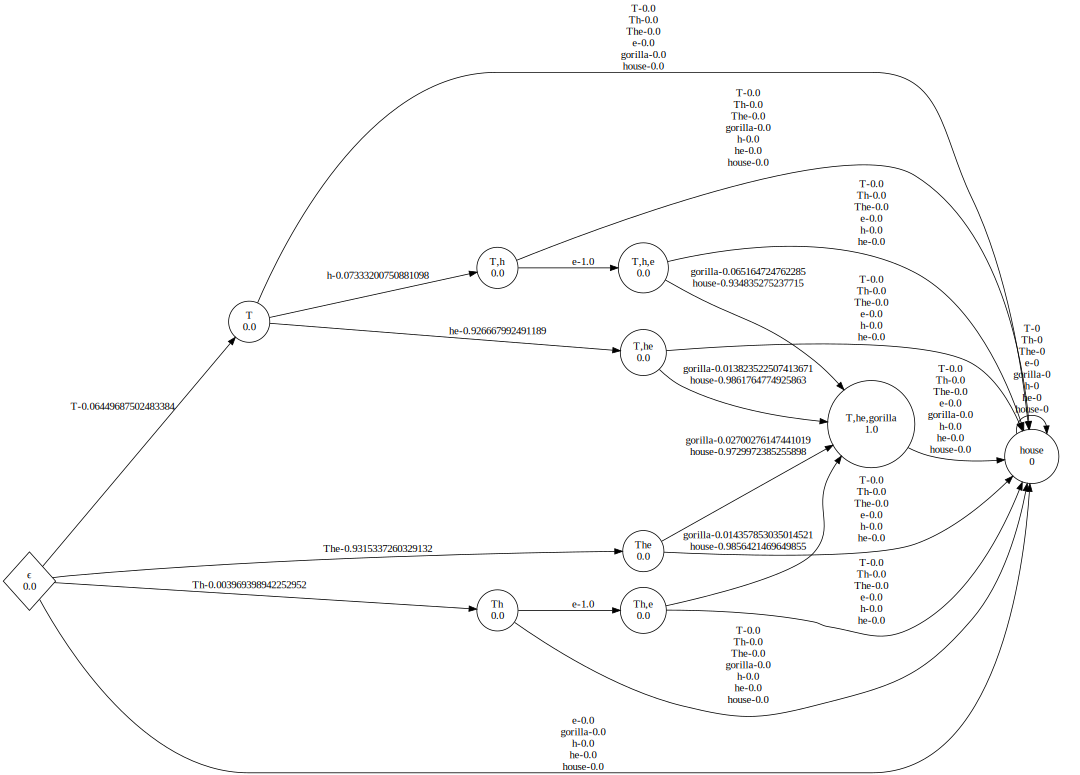

In [17]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(learning_result.model)

display(graph)